<a href="https://colab.research.google.com/github/Aya-Amin/MRnet-dataset-classification/blob/master/Assignment_4_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#downloading dataset to colab
!wget -qq http://download.cs.stanford.edu/deep/MRNet-v1.0.zip -P ./data

In [0]:
#unziping
!unzip --qq data/MRNet-v1.0.zip -d ./data

warning [data/MRNet-v1.0.zip]:  4294967296 extra bytes at beginning or within zipfile
  (attempting to process anyway)
file #1:  bad zipfile offset (local header sig):  4294967296
  (attempting to re-compensate)
file #2547:  bad zipfile offset (local header sig):  1353202
  (attempting to re-compensate)


In [0]:
import os
import numpy as np
from matplotlib import pyplot as plt
import math

In [0]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras import backend as K
from keras.layers import Input

Using TensorFlow backend.


In [0]:
import keras.backend as K

def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score
  

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

##Reading train & test labels

In [0]:
import csv

with open("/content/data/MRNet-v1.0/train-abnormal.csv") as csv_file:
    csv_reader = csv.reader(csv_file)
    line_count = 0
    trainAb_labels=[]
    for row in csv_reader:
           trainAb_labels.append(int(row[1]))
print(trainAb_labels)
trainAb_labels= np.array(trainAb_labels)
print(len(trainAb_labels))

with open("/content/data/MRNet-v1.0/train-acl.csv") as csv_file:
    csv_reader = csv.reader(csv_file)
    line_count = 0
    trainACL_labels=[]
    for row in csv_reader:
           trainACL_labels.append(int(row[1]))
print(trainAb_labels)
trainACL_labels= np.array(trainACL_labels)
print(len(trainACL_labels))


with open("/content/data/MRNet-v1.0/train-meniscus.csv") as csv_file:
    csv_reader = csv.reader(csv_file)
    line_count = 0
    trainMen_labels=[]
    for row in csv_reader:
           trainMen_labels.append(int(row[1]))
print(trainMen_labels)
trainAb_labels= np.array(trainMen_labels)
print(len(trainMen_labels))


#Test labels
with open("/content/data/MRNet-v1.0/valid-abnormal.csv") as csv_file:
    csv_reader = csv.reader(csv_file)
    line_count = 0
    testAb_labels=[]
    for row in csv_reader:
           testAb_labels.append(int(row[1]))
print(testAb_labels)
testAb_labels= np.array(testAb_labels)
print(len(testAb_labels))

with open("/content/data/MRNet-v1.0/valid-acl.csv") as csv_file:
    csv_reader = csv.reader(csv_file)
    line_count = 0
    testACL_labels=[]
    for row in csv_reader:
           testACL_labels.append(int(row[1]))
print(testACL_labels)
testACL_labels= np.array(testACL_labels)
print(len(testACL_labels))


with open("/content/data/MRNet-v1.0/valid-meniscus.csv") as csv_file:
    csv_reader = csv.reader(csv_file)
    line_count = 0
    testMen_labels=[]
    for row in csv_reader:
           testMen_labels.append(int(row[1]))
print(testMen_labels)
testMen_labels= np.array(testMen_labels)
print(len(testMen_labels))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [0]:
train_Ab_pred = []
test_Ab_pred = []
train_ACL_pred = []
test_ACL_pred = []
train_Men_pred = []
test_Men_pred = []

##Axial

###Reading train & test data

In [0]:
#reading axial directory in order
axial_dir = os.listdir("/content/data/MRNet-v1.0/train/axial/")
axial_dir = [f.lower() for f in axial_dir]   # Convert to lower case
a=sorted(axial_dir)
axial_list=np.array(a)
axial_reloaded=[]

print(axial_list.shape)
for j in range(1,1131):
    file= "/content/data/MRNet-v1.0/train/axial/"+axial_list[j]    
    axial_reloaded.append(np.load(file,allow_pickle='false'))   
#print(axial_reloaded[100].shape)
axial_reloaded=np.array(axial_reloaded)

print(axial_reloaded.shape)
s=axial_reloaded.shape
print(axial_reloaded[0].shape[0])
#print(s[1])
train_axial=[]

print(len(axial_reloaded))
#just potting the images 
for j in range(len(axial_reloaded)):
    mid=math.floor((axial_reloaded[j].shape[0])/2)
    train_axial.append([])    
    #genereting training set for axial
    for n in range(mid-1,mid+2):
         train_axial[j].append(axial_reloaded[j][n])
train_axial=np.array(train_axial)
train_axial=np.reshape(train_axial,(1130,256,256,3))
print(train_axial.shape)

#test data
#reading axial directory in order
axial_dir = os.listdir("/content/data/MRNet-v1.0/valid/axial/")
axial_dir = [f.lower() for f in axial_dir]   # Convert to lower case
a=sorted(axial_dir)
axialTest_list=np.array(a)
axialTest_reloaded=[]

print(axialTest_list.shape)

for j in range(0,120):
    file= "/content/data/MRNet-v1.0/valid/axial/"+axialTest_list[j]
    axialTest_reloaded.append(np.load(file,allow_pickle='false'))   
#print(axial_reloaded[100].shape)
axialTest_reloaded=np.array(axialTest_reloaded)

print(axialTest_reloaded.shape)

s=axialTest_reloaded.shape
print(axialTest_reloaded[0].shape[0])
#print(s[1])
test_axial=[]

print(len(axialTest_reloaded))
#just potting the images 
for j in range(len(axialTest_reloaded)):
    mid=math.floor((axialTest_reloaded[j].shape[0])/2)
    test_axial.append([])    
    #genereting training set for axial
    for n in range(mid-1,mid+2):
         test_axial[j].append(axialTest_reloaded[j][n])
test_axial=np.array(test_axial)
test_axial=np.reshape(test_axial,(120,256,256,3))
print(test_axial.shape)

(1131,)
(1130,)
44
1130
(1130, 256, 256, 3)
(120,)
(120,)
25
120
(120, 256, 256, 3)


###InceptionV3 Model for Axial Meniscus

In [0]:
# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(256, 256,3))  # this assumes K.image_data_format() == 'channels_last'
base_model_ax_men = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)
print(len(base_model_ax_men.layers))

Instructions for updating:
Colocations handled automatically by placer.
87916544/87910968 [==============================] - 1s 0us/step
311


In [0]:
x = base_model_ax_men.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
#base_model.output=x
# this is the model we will train
model = Model(inputs=base_model_ax_men.input,outputs=predictions)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
for layer in model.layers[:79]:
   layer.trainable = False
for layer in model.layers[79:]:
   layer.trainable = True

In [0]:
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
early_stopping_monitor = EarlyStopping(patience=10)    
model.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy', f1_score])
history=model.fit(train_axial ,trainMen_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 20)
#model.fit(train_axial,trainMen_labels,epochs=50,batch_size=1000,validation_split=0.05,verbose=2,callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode="min")])

Instructions for updating:
Use tf.cast instead.
Train on 1073 samples, validate on 57 samples
Epoch 1/100
1073/1073 [==============================] - 24s 22ms/step - loss: 0.6452 - acc: 0.6365 - f1_score: nan - val_loss: 5.0841 - val_acc: 0.5965 - val_f1_score: nan
Epoch 2/100
1073/1073 [==============================] - 9s 8ms/step - loss: 0.5401 - acc: 0.7241 - f1_score: nan - val_loss: 5.9742 - val_acc: 0.5965 - val_f1_score: nan
Epoch 3/100
1073/1073 [==============================] - 9s 8ms/step - loss: 0.4507 - acc: 0.7745 - f1_score: 0.6242 - val_loss: 4.3824 - val_acc: 0.6316 - val_f1_score: nan
Epoch 4/100
1073/1073 [==============================] - 9s 8ms/step - loss: 0.3356 - acc: 0.8583 - f1_score: 0.7842 - val_loss: 4.6365 - val_acc: 0.6140 - val_f1_score: 0.4659
Epoch 5/100
1073/1073 [==============================] - 9s 8ms/step - loss: 0.2232 - acc: 0.9301 - f1_score: 0.8922 - val_loss: 5.3748 - val_acc: 0.5789 - val_f1_score: 0.4721
Epoch 6/100
1073/1073 [===========

####Plotting accuracy of both training and validation sets per epoch.

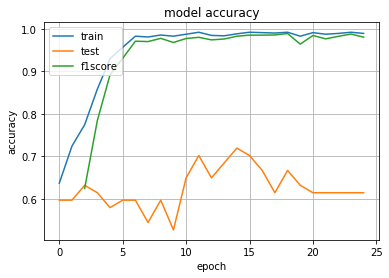

In [0]:
p = np.array(model.predict(train_axial))
train_Men_pred.append(p)
p = np.array(model.predict(test_axial))
test_Men_pred.append(p)

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.plot(history.history['f1_score'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test', 'f1score'], loc='upper left')
plt.grid() 
plt.show()

###InceptionV3 Model for Axial ACL

In [0]:
# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(256, 256,3))  # this assumes K.image_data_format() == 'channels_last'
base_model_ax_ACL = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [0]:
x = base_model_ax_ACL.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
#base_model.output=x
# this is the model we will train
model2 = Model(inputs=base_model_ax_ACL.input,outputs=predictions)

In [0]:
for layer in model2.layers[:79]:
   layer.trainable = False
for layer in model2.layers[79:]:
   layer.trainable = True

In [0]:
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
early_stopping_monitor = EarlyStopping(patience=10)    
model2.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy',f1_score])
history2=model2.fit(train_axial ,trainACL_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 20)
#model.fit(train_axial,trainMen_labels,epochs=50,batch_size=1000,validation_split=0.05,verbose=2,callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode="min")])

Train on 1073 samples, validate on 57 samples
Epoch 1/100
1073/1073 [==============================] - 19s 18ms/step - loss: 0.4985 - acc: 0.7940 - f1_score: nan - val_loss: 2.5450 - val_acc: 0.8421 - val_f1_score: nan
Epoch 2/100
1073/1073 [==============================] - 9s 9ms/step - loss: 0.3677 - acc: 0.8220 - f1_score: nan - val_loss: 2.5450 - val_acc: 0.8421 - val_f1_score: nan
Epoch 3/100
1073/1073 [==============================] - 9s 9ms/step - loss: 0.2824 - acc: 0.8537 - f1_score: nan - val_loss: 2.5450 - val_acc: 0.8421 - val_f1_score: nan
Epoch 4/100
1073/1073 [==============================] - 9s 9ms/step - loss: 0.2116 - acc: 0.9171 - f1_score: nan - val_loss: 2.5450 - val_acc: 0.8421 - val_f1_score: nan
Epoch 5/100
1073/1073 [==============================] - 9s 9ms/step - loss: 0.1277 - acc: 0.9646 - f1_score: nan - val_loss: 2.5450 - val_acc: 0.8421 - val_f1_score: nan
Epoch 6/100
1073/1073 [==============================] - 9s 9ms/step - loss: 0.0732 - acc: 0.9888

120/120 [==============================] - 0s 3ms/step
Train loss: 6.877885214487711
Train accuracy: 0.5583333333333333


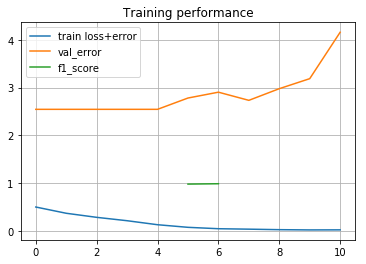

In [0]:
p = np.array(model2.predict(train_axial))
train_ACL_pred.append(p)
p = np.array(model2.predict(test_axial))
test_ACL_pred.append(p)

# Show simple version of performance                           
score2 = model2.evaluate(test_axial ,testACL_labels,verbose=1)       
print('Train loss:',score2[0])
print('Train accuracy:',score2[1])                          
# Show loss curves                                          
plt.figure()
plt.grid()                                              
                                                            
plt.title('Training performance')                          
plt.plot(history2.epoch, history2.history['loss'], label='train loss+error')  
plt.plot(history2.epoch, history2.history['val_loss'], label='val_error')
plt.plot(history2.epoch, history2.history['f1_score'], label='f1_score')
plt.legend()

###InceptionV3 Model for Axial Abnormal

In [0]:
# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(256, 256,3))  # this assumes K.image_data_format() == 'channels_last'
base_model_ax_AB = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [0]:
x = base_model_ax_AB.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
#base_model.output=x
# this is the model we will train
model3 = Model(inputs=base_model_ax_AB.input,outputs=predictions)

In [0]:
for layer in model3.layers[:79]:
   layer.trainable = False
for layer in model3.layers[79:]:
   layer.trainable = True

In [0]:
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
early_stopping_monitor = EarlyStopping(patience=10)    
model3.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy',f1_score])
history3=model3.fit(train_axial ,trainAb_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 20)
#model.fit(train_axial,trainMen_labels,epochs=50,batch_size=1000,validation_split=0.05,verbose=2,callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode="min")])

Train on 1073 samples, validate on 57 samples
Epoch 1/100
1073/1073 [==============================] - 23s 22ms/step - loss: 0.0361 - acc: 0.9888 - f1_score: 0.9850 - val_loss: 6.2210 - val_acc: 0.6140 - val_f1_score: nan
Epoch 2/100
1073/1073 [==============================] - 9s 9ms/step - loss: 0.0565 - acc: 0.9814 - f1_score: 0.9641 - val_loss: 6.2210 - val_acc: 0.6140 - val_f1_score: nan
Epoch 3/100
1073/1073 [==============================] - 10s 9ms/step - loss: 0.0246 - acc: 0.9953 - f1_score: 0.9914 - val_loss: 6.2210 - val_acc: 0.6140 - val_f1_score: nan
Epoch 4/100
1073/1073 [==============================] - 9s 9ms/step - loss: 0.0307 - acc: 0.9907 - f1_score: 0.9769 - val_loss: 6.2210 - val_acc: 0.6140 - val_f1_score: nan
Epoch 5/100
1073/1073 [==============================] - 9s 9ms/step - loss: 0.0278 - acc: 0.9916 - f1_score: 0.9861 - val_loss: 6.2210 - val_acc: 0.6140 - val_f1_score: nan
Epoch 6/100
1073/1073 [==============================] - 9s 9ms/step - loss: 0.02

120/120 [==============================] - 0s 3ms/step
Test loss: 12.760158793131511
Test accuracy: 0.20833333333333334


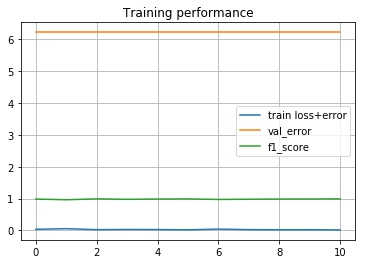

In [0]:
p = np.array(model3.predict(train_axial))
train_Ab_pred.append(p)
p = np.array(model3.predict(test_axial))
test_Ab_pred.append(p)

# Show simple version of performance                           
score3 = model3.evaluate(test_axial ,testAb_labels,verbose=1)       
print('Test loss:',score3[0])
print('Test accuracy:',score3[1])                          
# Show loss curves                                          
plt.figure()
plt.grid()                                              
                                                            
plt.title('Training performance')                          
plt.plot(history3.epoch, history3.history['loss'], label='train loss+error')  
plt.plot(history3.epoch, history3.history['val_loss'], label='val_error') 
plt.plot(history3.epoch, history3.history['f1_score'], label='f1_score') 
plt.legend()

In [0]:
del train_axial
del test_axial
del axial_dir
del axial_reloaded
del axialTest_reloaded
del axial_list
del axialTest_list

del model
del model2
del model3

del base_model_ax_men
del base_model_ax_ACL
del base_model_ax_AB

del p


##Coronal

###Reading train & test data

In [0]:
#reading coronal directery in order
coronal_dir = os.listdir("/content/data/MRNet-v1.0/train/coronal/")
coronal_dir = [f.lower() for f in coronal_dir]   # Convert to lower case
c=sorted(coronal_dir)
coronal_list=np.array(c)
coronal_reloaded=[]
print(coronal_list.shape)
for j in range(1,1131):
    file2= "/content/data/MRNet-v1.0/train/coronal/"+coronal_list[j]
    coronal_reloaded.append(np.load(file2,allow_pickle='false'))

coronal_reloaded=np.array(coronal_reloaded)
print(coronal_reloaded.shape)
train_coronal=[]
 
for j in range(len(coronal_reloaded)):
    mid2=math.floor((coronal_reloaded[j].shape[0])/2)
    train_coronal.append([])
    #genereting training set for coronal    
    for n in range(mid2-1,mid2+2):
         train_coronal[j].append(coronal_reloaded[j][n])

train_coronal=np.array(train_coronal)
train_coronal=np.reshape(train_coronal,(1130,256,256,3))
print(train_coronal.shape)


#Test
#reading coronal directery in order
coronal_dir = os.listdir("/content/data/MRNet-v1.0/valid/coronal/")
coronal_dir = [f.lower() for f in coronal_dir]   # Convert to lower case
c=sorted(coronal_dir)
coronalTest_list=np.array(c)
coronalTest_reloaded=[]
print(coronalTest_list.shape)
for j in range(0,120):
    file2= "/content/data/MRNet-v1.0/valid/coronal/"+coronalTest_list[j]
    coronalTest_reloaded.append(np.load(file2,allow_pickle='false'))

coronalTest_reloaded=np.array(coronalTest_reloaded)
print(coronalTest_reloaded.shape)
test_coronal=[]
 
for j in range(len(coronalTest_reloaded)):
    mid2=math.floor((coronalTest_reloaded[j].shape[0])/2)
    test_coronal.append([])
    #genereting training set for coronal    
    for n in range(mid2-1,mid2+2):
         test_coronal[j].append(coronalTest_reloaded[j][n])

test_coronal=np.array(test_coronal)
test_coronal=np.reshape(test_coronal,(120,256,256,3))
print(test_coronal.shape)



(1131,)
(1130,)
(1130, 256, 256, 3)
(120,)
(120,)
(120, 256, 256, 3)


###InceptionV3 Model for Coronal Menscuis

In [0]:
# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(256, 256,3))  # this assumes K.image_data_format() == 'channels_last'
base_model_Co_Men = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [0]:
x = base_model_Co_Men.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
#base_model.output=x
# this is the model we will train
model4 = Model(inputs=base_model_Co_Men.input,outputs=predictions)

In [0]:
for layer in model4.layers[:79]:
   layer.trainable = False
for layer in model4.layers[79:]:
   layer.trainable = True

In [0]:
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
early_stopping_monitor = EarlyStopping(patience=5)    
model4.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy',f1_score])
history4=model4.fit(train_coronal ,trainMen_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 20)
#model.fit(train_axial,trainMen_labels,epochs=50,batch_size=1000,validation_split=0.05,verbose=2,callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode="min")])

Train on 1073 samples, validate on 57 samples
Epoch 1/100
1073/1073 [==============================] - 27s 25ms/step - loss: 0.6604 - acc: 0.6244 - f1_score: nan - val_loss: 6.5609 - val_acc: 0.5789 - val_f1_score: nan
Epoch 2/100
1073/1073 [==============================] - 10s 9ms/step - loss: 0.5640 - acc: 0.6952 - f1_score: nan - val_loss: 9.3702 - val_acc: 0.3684 - val_f1_score: 0.2162
Epoch 3/100
1073/1073 [==============================] - 10s 9ms/step - loss: 0.4794 - acc: 0.7679 - f1_score: 0.6148 - val_loss: 6.8206 - val_acc: 0.5439 - val_f1_score: nan
Epoch 4/100
1073/1073 [==============================] - 9s 9ms/step - loss: 0.3598 - acc: 0.8565 - f1_score: 0.7685 - val_loss: 8.8021 - val_acc: 0.3860 - val_f1_score: 0.5040
Epoch 5/100
1073/1073 [==============================] - 9s 9ms/step - loss: 0.2175 - acc: 0.9348 - f1_score: 0.9000 - val_loss: 8.6858 - val_acc: 0.4035 - val_f1_score: 0.4834
Epoch 6/100
1073/1073 [==============================] - 9s 9ms/step - loss: 

120/120 [==============================] - 0s 4ms/step
Test loss: 8.38684416214625
Test accuracy: 0.45833332935969034


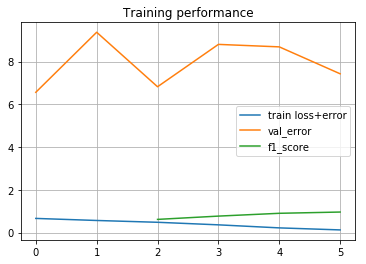

In [0]:
p = np.array(model4.predict(train_coronal))
train_Men_pred.append(p)
p = np.array(model4.predict(test_coronal))
test_Men_pred.append(p)

score4 = model4.evaluate(test_coronal ,testMen_labels,verbose=1)       
print('Test loss:',score4[0])
print('Test accuracy:',score4[1])                          
# Show loss curves                                          
plt.figure()
plt.grid()                                              
                                                            
plt.title('Training performance')                          
plt.plot(history4.epoch, history4.history['loss'], label='train loss+error')  
plt.plot(history4.epoch, history4.history['val_loss'], label='val_error')  
plt.plot(history4.epoch, history4.history['f1_score'], label='f1_score')  
plt.legend()

###InceptionV3 Model for Coronal ACL

In [0]:
# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(256, 256,3))  # this assumes K.image_data_format() == 'channels_last'
base_model_Co_ACL = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [0]:
x = base_model_Co_ACL.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
#base_model.output=x
# this is the model we will train
model5 = Model(inputs=base_model_Co_ACL.input,outputs=predictions)

In [0]:
for layer in model5.layers[:79]:
   layer.trainable = False
for layer in model5.layers[79:]:
   layer.trainable = True

In [0]:
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
early_stopping_monitor = EarlyStopping(patience=10)    
model5.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy',f1_score])
history5=model5.fit(train_coronal ,trainACL_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 20)
#model.fit(train_axial,trainMen_labels,epochs=50,batch_size=1000,validation_split=0.05,verbose=2,callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode="min")])

Train on 1073 samples, validate on 57 samples
Epoch 1/100
1073/1073 [==============================] - 32s 30ms/step - loss: 0.5396 - acc: 0.7698 - f1_score: nan - val_loss: 2.5450 - val_acc: 0.8421 - val_f1_score: nan
Epoch 2/100
1073/1073 [==============================] - 10s 9ms/step - loss: 0.4138 - acc: 0.8145 - f1_score: nan - val_loss: 2.3338 - val_acc: 0.8421 - val_f1_score: nan
Epoch 3/100
1073/1073 [==============================] - 10s 9ms/step - loss: 0.3400 - acc: 0.8360 - f1_score: nan - val_loss: 3.3430 - val_acc: 0.7368 - val_f1_score: nan
Epoch 4/100
1073/1073 [==============================] - 9s 9ms/step - loss: 0.2057 - acc: 0.9133 - f1_score: nan - val_loss: 6.7232 - val_acc: 0.5789 - val_f1_score: 0.3603
Epoch 5/100
1073/1073 [==============================] - 9s 9ms/step - loss: 0.1189 - acc: 0.9767 - f1_score: 0.9439 - val_loss: 9.6107 - val_acc: 0.3860 - val_f1_score: 0.3382
Epoch 6/100
1073/1073 [==============================] - 9s 9ms/step - loss: 0.0677 - 

120/120 [==============================] - 0s 4ms/step
Test loss: 8.768311882019043
Test accuracy: 0.45


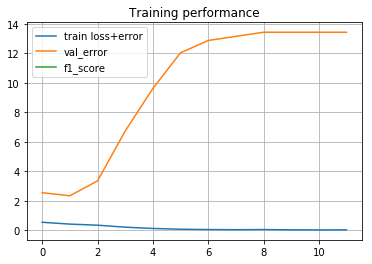

In [0]:
p = np.array(model5.predict(train_coronal))
train_ACL_pred.append(p)
p = np.array(model5.predict(test_coronal, verbose=1))
test_ACL_pred.append(p)

# Show simple version of performance                           
score5 = model5.evaluate(test_coronal ,testACL_labels,verbose=1)       
print('Test loss:',score5[0])
print('Test accuracy:',score5[1])                          
# Show loss curves                                          
plt.figure()
plt.grid()                                              
                                                            
plt.title('Training performance')                          
plt.plot(history5.epoch, history5.history['loss'], label='train loss+error')  
plt.plot(history5.epoch, history5.history['val_loss'], label='val_error') 
plt.plot(history5.epoch, history5.history['f1_score'], label='f1_score') 
plt.legend()

###InceptionV3 Model for Coronal Abnormal

In [0]:
# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(256, 256,3))  # this assumes K.image_data_format() == 'channels_last'
base_model_Co_Ab = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [0]:
x = base_model_Co_Ab.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
#base_model.output=x
# this is the model we will train
model6 = Model(inputs=base_model_Co_Ab.input,outputs=predictions)

In [0]:
for layer in model6.layers[:79]:
   layer.trainable = False
for layer in model6.layers[79:]:
   layer.trainable = True

In [0]:
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
early_stopping_monitor = EarlyStopping(patience=10)    
model6.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy',f1_score])
history6=model6.fit(train_coronal ,trainAb_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 20)
#model.fit(train_axial,trainMen_labels,epochs=50,batch_size=1000,validation_split=0.05,verbose=2,callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode="min")])

Train on 1073 samples, validate on 57 samples
Epoch 1/100
1073/1073 [==============================] - 37s 34ms/step - loss: 0.6674 - acc: 0.6235 - f1_score: nan - val_loss: 9.7377 - val_acc: 0.3684 - val_f1_score: 0.5295
Epoch 2/100
1073/1073 [==============================] - 10s 9ms/step - loss: 0.5590 - acc: 0.7083 - f1_score: nan - val_loss: 9.0356 - val_acc: 0.4211 - val_f1_score: 0.5399
Epoch 3/100
1073/1073 [==============================] - 10s 9ms/step - loss: 0.4388 - acc: 0.7978 - f1_score: 0.6581 - val_loss: 9.8092 - val_acc: 0.3509 - val_f1_score: 0.5133
Epoch 4/100
1073/1073 [==============================] - 10s 9ms/step - loss: 0.3393 - acc: 0.8555 - f1_score: 0.7640 - val_loss: 9.7892 - val_acc: 0.3860 - val_f1_score: 0.5514
Epoch 5/100
1073/1073 [==============================] - 9s 9ms/step - loss: 0.2018 - acc: 0.9348 - f1_score: 0.9044 - val_loss: 9.7892 - val_acc: 0.3860 - val_f1_score: 0.5514
Epoch 6/100
1073/1073 [==============================] - 9s 9ms/step -

120/120 [==============================] - 0s 4ms/step
Test loss: 3.321330364545206
Test accuracy: 0.7916666666666666


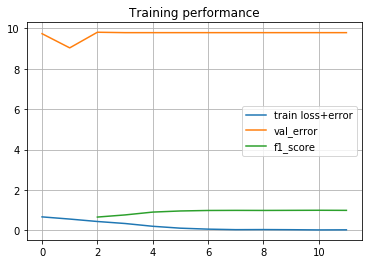

In [0]:
p = np.array(model6.predict(train_coronal))
train_Ab_pred.append(p)
p = np.array(model6.predict(test_coronal))
test_Ab_pred.append(p)

# Show simple version of performance                           
score6 = model6.evaluate(test_coronal ,testAb_labels,verbose=1)       
print('Test loss:',score6[0])
print('Test accuracy:',score6[1])                          
# Show loss curves                                          
plt.figure()
plt.grid()                                              
                                                            
plt.title('Training performance')                          
plt.plot(history6.epoch, history6.history['loss'], label='train loss+error')  
plt.plot(history6.epoch, history6.history['val_loss'], label='val_error')   
plt.plot(history6.epoch, history6.history['f1_score'], label='f1_score')   
plt.legend()

In [0]:
del train_coronal
del test_coronal
del coronal_dir
del coronal_reloaded
del coronalTest_reloaded
del coronal_list
del coronalTest_list

del model4
del model5
del model6

del base_model_Co_Men
del base_model_Co_ACL
del base_model_Co_Ab

del p


##Sagittal

###Reading train & test data

In [0]:
#reading sagittal directery in order
sagittal_dir = os.listdir("/content/data/MRNet-v1.0/train/sagittal/")
sagittal_dir = [f.lower() for f in sagittal_dir]   # Convert to lower case
c=sorted(sagittal_dir)
sagittal_list=np.array(c)
sagittal_reloaded=[]
print(sagittal_list.shape)
for j in range(1,1131):
    file2= "/content/data/MRNet-v1.0/train/sagittal/"+sagittal_list[j]
    sagittal_reloaded.append(np.load(file2,allow_pickle='false'))

sagittal_reloaded=np.array(sagittal_reloaded)
print(sagittal_reloaded.shape)
train_sagittal=[]
 
for j in range(len(sagittal_reloaded)):
    mid2=math.floor((sagittal_reloaded[j].shape[0])/2)
    train_sagittal.append([])
    #genereting training set for sagittal   
    for n in range(mid2-1,mid2+2):
         train_sagittal[j].append(sagittal_reloaded[j][n])

train_sagittal=np.array(train_sagittal)
train_sagittal=np.reshape(train_sagittal,(1130,256,256,3))
print(train_sagittal.shape)


#Test
#reading sagittal directery in order
sagittal_dir = os.listdir("/content/data/MRNet-v1.0/valid/sagittal/")
sagittal_dir = [f.lower() for f in sagittal_dir]   # Convert to lower case
c=sorted(sagittal_dir)
sagittalTest_list=np.array(c)
sagittalTest_reloaded=[]
print(sagittalTest_list.shape)
for j in range(0,120):
    file2= "/content/data/MRNet-v1.0/valid/sagittal/"+sagittalTest_list[j]
    sagittalTest_reloaded.append(np.load(file2,allow_pickle='false'))

sagittalTest_reloaded=np.array(sagittalTest_reloaded)
print(sagittalTest_reloaded.shape)
test_sagittal=[]
 
for j in range(len(sagittalTest_reloaded)):
    mid2=math.floor((sagittalTest_reloaded[j].shape[0])/2)
    test_sagittal.append([])
    #genereting training set for sagittal   
    for n in range(mid2-1,mid2+2):
         test_sagittal[j].append(sagittalTest_reloaded[j][n])

test_sagittal=np.array(test_sagittal)
test_sagittal=np.reshape(test_sagittal,(120,256,256,3))
print(test_sagittal.shape)



(1131,)
(1130,)
(1130, 256, 256, 3)
(120,)
(120,)
(120, 256, 256, 3)


###InceptionV3 Model for Sagittal Mensical

In [0]:
# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(256, 256,3))  # this assumes K.image_data_format() == 'channels_last'
base_model_Sa_Men = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [0]:
x = base_model_Sa_Men.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
#base_model.output=x
# this is the model we will train
model7 = Model(inputs=base_model_Sa_Men.input,outputs=predictions)

In [0]:
for layer in model7.layers[:79]:
   layer.trainable = False
for layer in model7.layers[79:]:
   layer.trainable = True

In [0]:
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
early_stopping_monitor = EarlyStopping(patience=10)    
model7.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy',f1_score])
history7=model7.fit(train_sagittal ,trainMen_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 20)
#model.fit(train_axial,trainMen_labels,epochs=50,batch_size=1000,validation_split=0.05,verbose=2,callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode="min")])

Train on 1073 samples, validate on 57 samples
Epoch 1/100
1073/1073 [==============================] - 42s 39ms/step - loss: 0.6793 - acc: 0.6170 - f1_score: nan - val_loss: 6.2210 - val_acc: 0.6140 - val_f1_score: nan
Epoch 2/100
1073/1073 [==============================] - 10s 9ms/step - loss: 0.5574 - acc: 0.6952 - f1_score: nan - val_loss: 6.2210 - val_acc: 0.6140 - val_f1_score: nan
Epoch 3/100
1073/1073 [==============================] - 10s 9ms/step - loss: 0.4476 - acc: 0.7940 - f1_score: 0.6580 - val_loss: 6.2210 - val_acc: 0.6140 - val_f1_score: nan
Epoch 4/100
1073/1073 [==============================] - 10s 9ms/step - loss: 0.3043 - acc: 0.8816 - f1_score: 0.8167 - val_loss: 6.2210 - val_acc: 0.6140 - val_f1_score: nan
Epoch 5/100
1073/1073 [==============================] - 10s 9ms/step - loss: 0.1644 - acc: 0.9497 - f1_score: 0.9235 - val_loss: 6.2210 - val_acc: 0.6140 - val_f1_score: nan
Epoch 6/100
1073/1073 [==============================] - 9s 9ms/step - loss: 0.0731 

120/120 [==============================] - 0s 4ms/step
Test loss: 6.9845082867578165
Test accuracy: 0.5666666666666667


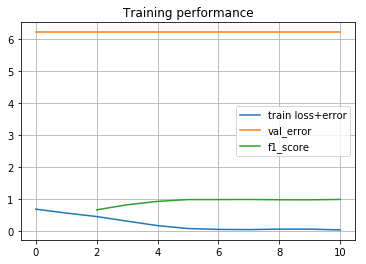

In [0]:
p = np.array(model7.predict(train_sagittal))
train_Men_pred.append(p)
p = np.array(model7.predict(test_sagittal))
test_Men_pred.append(p)

# Show simple version of performance                           
score7 = model7.evaluate(test_sagittal ,testMen_labels,verbose=1)       
print('Test loss:',score7[0])
print('Test accuracy:',score7[1])                          
# Show loss curves                                          
plt.figure()
plt.grid()                                              
                                                            
plt.title('Training performance')                          
plt.plot(history7.epoch, history7.history['loss'], label='train loss+error')  
plt.plot(history7.epoch, history7.history['val_loss'], label='val_error')
plt.plot(history7.epoch, history7.history['f1_score'], label='f1_score')
plt.legend()

###InceptionV3 Model for Sagittal ACL

In [0]:
# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(256, 256,3))  # this assumes K.image_data_format() == 'channels_last'
base_model_Sa_ACL = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [0]:
x = base_model_Sa_ACL.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
#base_model.output=x
# this is the model we will train
model8 = Model(inputs=base_model_Sa_ACL.input,outputs=predictions)

In [0]:
for layer in model8.layers[:79]:
   layer.trainable = False
for layer in model8.layers[79:]:
   layer.trainable = True

In [0]:
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
early_stopping_monitor = EarlyStopping(patience=5)    
model8.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy',f1_score])
history8=model8.fit(train_sagittal ,trainACL_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 20)
#model.fit(train_axial,trainMen_labels,epochs=50,batch_size=1000,validation_split=0.05,verbose=2,callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode="min")])

Train on 1073 samples, validate on 57 samples
Epoch 1/100
1073/1073 [==============================] - 48s 45ms/step - loss: 0.4983 - acc: 0.8052 - f1_score: nan - val_loss: 2.5450 - val_acc: 0.8421 - val_f1_score: nan
Epoch 2/100
1073/1073 [==============================] - 10s 9ms/step - loss: 0.3940 - acc: 0.8192 - f1_score: nan - val_loss: 2.5450 - val_acc: 0.8421 - val_f1_score: nan
Epoch 3/100
1073/1073 [==============================] - 10s 9ms/step - loss: 0.2960 - acc: 0.8527 - f1_score: nan - val_loss: 2.5450 - val_acc: 0.8421 - val_f1_score: nan
Epoch 4/100
1073/1073 [==============================] - 10s 9ms/step - loss: 0.1942 - acc: 0.9199 - f1_score: nan - val_loss: 2.5453 - val_acc: 0.8421 - val_f1_score: nan
Epoch 5/100
1073/1073 [==============================] - 9s 9ms/step - loss: 0.1097 - acc: 0.9795 - f1_score: 0.9426 - val_loss: 2.5788 - val_acc: 0.8246 - val_f1_score: nan
Epoch 6/100
1073/1073 [==============================] - 9s 9ms/step - loss: 0.0652 - acc: 

120/120 [==============================] - 0s 4ms/step
Test loss: 7.515199247996012
Test accuracy: 0.525


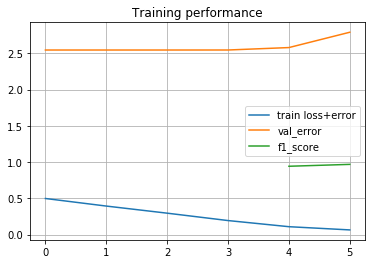

In [0]:
p = np.array(model8.predict(train_sagittal))
train_ACL_pred.append(p)
p = np.array(model8.predict(test_sagittal))
test_ACL_pred.append(p)

# Show simple version of performance                           
score8 = model8.evaluate(test_sagittal ,testACL_labels,verbose=1)       
print('Test loss:',score8[0])
print('Test accuracy:',score8[1])                          
# Show loss curves                                          
plt.figure()
plt.grid()                                              
                                                            
plt.title('Training performance')                          
plt.plot(history8.epoch, history8.history['loss'], label='train loss+error')  
plt.plot(history8.epoch, history8.history['val_loss'], label='val_error')
plt.plot(history8.epoch, history8.history['f1_score'], label='f1_score')
plt.legend()

###InceptionV3 Model for Sagittal Abnormal

In [0]:
# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(256, 256,3))  # this assumes K.image_data_format() == 'channels_last'
base_model_Sa_Ab = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [0]:
x = base_model_Sa_Ab.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x=Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.2)(x)
x=Dropout(0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)
#base_model.output=x
# this is the model we will train
model9 = Model(inputs=base_model_Sa_Ab.input,outputs=predictions)

In [0]:
for layer in model9.layers[:79]:
   layer.trainable = False
for layer in model9.layers[79:]:
   layer.trainable = True

In [0]:
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD
early_stopping_monitor = EarlyStopping(patience=10)    
model9.compile(optimizer=SGD(lr=0.001,momentum=0.9), loss='binary_crossentropy',metrics=['accuracy',f1_score])
history9=model9.fit(train_sagittal ,trainAb_labels, validation_split=0.05,shuffle=True ,epochs=100, callbacks=[early_stopping_monitor], batch_size = 20)
#model.fit(train_axial,trainMen_labels,epochs=50,batch_size=1000,validation_split=0.05,verbose=2,callbacks=[EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode="min")])

Train on 1073 samples, validate on 57 samples
Epoch 1/100
1073/1073 [==============================] - 55s 51ms/step - loss: 0.6702 - acc: 0.6226 - f1_score: nan - val_loss: 6.0757 - val_acc: 0.6140 - val_f1_score: nan
Epoch 2/100
1073/1073 [==============================] - 10s 9ms/step - loss: 0.5484 - acc: 0.7148 - f1_score: nan - val_loss: 6.0940 - val_acc: 0.6140 - val_f1_score: nan
Epoch 3/100
1073/1073 [==============================] - 10s 9ms/step - loss: 0.4463 - acc: 0.7940 - f1_score: 0.6599 - val_loss: 5.5596 - val_acc: 0.6316 - val_f1_score: nan
Epoch 4/100
1073/1073 [==============================] - 10s 9ms/step - loss: 0.3068 - acc: 0.8910 - f1_score: 0.8290 - val_loss: 6.8546 - val_acc: 0.4561 - val_f1_score: 0.3825
Epoch 5/100
1073/1073 [==============================] - 10s 9ms/step - loss: 0.1808 - acc: 0.9534 - f1_score: 0.9281 - val_loss: 7.8137 - val_acc: 0.4386 - val_f1_score: 0.5294
Epoch 6/100
1073/1073 [==============================] - 9s 9ms/step - loss: 0

120/120 [==============================] - 0s 4ms/step
Test loss: 10.982704162597656
Test accuracy: 0.3083333323399226


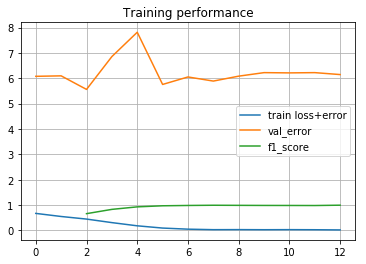

In [0]:
p = np.array(model9.predict(train_sagittal))
train_Ab_pred.append(p)
p = np.array(model9.predict(test_sagittal))
test_Ab_pred.append(p)

# Show simple version of performance                           
score9 = model9.evaluate(test_sagittal ,testAb_labels,verbose=1)       
print('Test loss:',score9[0])
print('Test accuracy:',score9[1])                          
# Show loss curves                                          
plt.figure()
plt.grid()                                              
                                                            
plt.title('Training performance')                          
plt.plot(history9.epoch, history9.history['loss'], label='train loss+error')  
plt.plot(history9.epoch, history9.history['val_loss'], label='val_error')
plt.plot(history9.epoch, history9.history['f1_score'], label='f1_score')
plt.legend()

In [0]:
del train_sagittal
del test_sagittal
del sagittal_dir
del sagittal_reloaded
del sagittalTest_reloaded
del sagittal_list
del sagittalTest_list

del model7
del model8
del model9

del base_model_Sa_Men
del base_model_Sa_ACL
del base_model_Sa_Ab

del p

##Ensembling

###Meniscal

In [0]:
train_Men_pred = np.array(train_Men_pred)
print(train_Men_pred.shape)
test_Men_pred = np.array(test_Men_pred)
print(test_Men_pred.shape)

train_Men_pred = train_Men_pred.reshape((1130,3))
test_Men_pred = test_Men_pred.reshape((120,3))
print(train_Men_pred)

(3, 1130, 1)
(3, 120, 1)
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [0]:
menModel = Sequential()
menModel.add(Dense(1, activation='sigmoid', input_dim=3))

menModel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',f1_score])
h = menModel.fit(train_Men_pred, trainMen_labels, batch_size=32, epochs=50, verbose=1)

Epoch 1/50
1130/1130 [==============================] - 40s 35ms/step - loss: 0.6961 - acc: 0.5850 - f1_score: nan
Epoch 2/50
1130/1130 [==============================] - 0s 236us/step - loss: 0.6884 - acc: 0.6257 - f1_score: nan
Epoch 3/50
1130/1130 [==============================] - 0s 241us/step - loss: 0.6821 - acc: 0.6434 - f1_score: nan
Epoch 4/50
1130/1130 [==============================] - 0s 234us/step - loss: 0.6769 - acc: 0.6460 - f1_score: nan
Epoch 5/50
1130/1130 [==============================] - 0s 237us/step - loss: 0.6729 - acc: 0.6460 - f1_score: nan
Epoch 6/50
1130/1130 [==============================] - 0s 233us/step - loss: 0.6696 - acc: 0.6442 - f1_score: nan
Epoch 7/50
1130/1130 [==============================] - 0s 246us/step - loss: 0.6669 - acc: 0.6434 - f1_score: nan
Epoch 8/50
1130/1130 [==============================] - 0s 238us/step - loss: 0.6645 - acc: 0.6434 - f1_score: nan
Epoch 9/50
1130/1130 [==============================] - 0s 234us/step - loss: 0.

120/120 [==============================] - 0s 337us/step
Loss:  0.6971778392791748
Accuracy:  0.5666666666666667


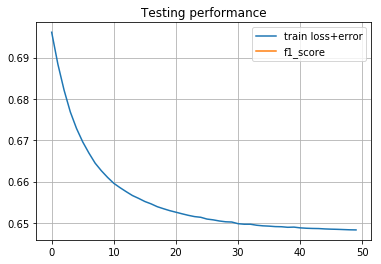

In [0]:
loss, acc, f1 = menModel.evaluate(test_Men_pred, testMen_labels)
p1 = menModel.predict(test_Men_pred)
print("Loss: ", loss)
print('Accuracy: ', acc)                       
# Show loss curves                                          
plt.figure()
plt.grid()                                              
                                                            
plt.title('Testing performance')                          
plt.plot(h.epoch, h.history['loss'], label='train loss+error')  
plt.plot(h.epoch, h.history['f1_score'], label='f1_score')
plt.legend()

In [0]:
del train_Men_pred
del menModel

###ACL

In [0]:
train_ACL_pred = np.array(train_ACL_pred)
print(train_ACL_pred.shape)
test_ACL_pred = np.array(test_ACL_pred)
print(test_Men_pred.shape)

train_ACL_pred = train_ACL_pred.reshape((1130,3))
test_ACL_pred = test_ACL_pred.reshape((120,3))
print(test_ACL_pred)

(3, 1130, 1)
(120, 3)
[[0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 9.2228138e-01 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 9.5201337e-01]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [9.9243468e-01 0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 3.7060529e-01 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0

In [0]:
menModel = Sequential()
menModel.add(Dense(1, activation='sigmoid', input_dim=3))

menModel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',f1])
h = menModel.fit(train_ACL_pred, trainACL_labels, batch_size=32, epochs=50, verbose=1)

Epoch 1/50
1130/1130 [==============================] - 40s 36ms/step - loss: 0.9080 - acc: 0.5071 - f1: 0.2282
Epoch 2/50
1130/1130 [==============================] - 0s 245us/step - loss: 0.8710 - acc: 0.5124 - f1: 0.2246
Epoch 3/50
1130/1130 [==============================] - 0s 237us/step - loss: 0.8361 - acc: 0.5124 - f1: 0.2311
Epoch 4/50
1130/1130 [==============================] - 0s 237us/step - loss: 0.8040 - acc: 0.5159 - f1: 0.2300
Epoch 5/50
1130/1130 [==============================] - 0s 238us/step - loss: 0.7741 - acc: 0.5168 - f1: 0.2209
Epoch 6/50
1130/1130 [==============================] - 0s 245us/step - loss: 0.7463 - acc: 0.5168 - f1: 0.2260
Epoch 7/50
1130/1130 [==============================] - 0s 235us/step - loss: 0.7211 - acc: 0.5168 - f1: 0.2295
Epoch 8/50
1130/1130 [==============================] - 0s 237us/step - loss: 0.6977 - acc: 0.5195 - f1: 0.2282
Epoch 9/50
1130/1130 [==============================] - 0s 241us/step - loss: 0.6767 - acc: 0.5301 - f1:

120/120 [==============================] - 19s 155ms/step
Loss:  0.9375431060791015
Accuracy:  0.55


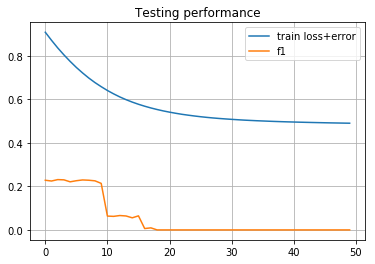

In [0]:
loss, acc, f1 = menModel.evaluate(test_ACL_pred, testACL_labels)
p2 = menModel.predict(test_ACL_pred)
print("Loss: ", loss)
print('Accuracy: ', acc)
# Show loss curves                                          
plt.figure()
plt.grid()                                              
                                                            
plt.title('Testing performance')                          
plt.plot(h.epoch, h.history['loss'], label='train loss+error')  
plt.plot(h.epoch, h.history['f1'], label='f1')
plt.legend()

In [0]:
del train_ACL_pred
del menModel

###Abnormal

In [0]:
train_Ab_pred = np.array(train_Ab_pred)
print(train_Ab_pred.shape)
test_Ab_pred = np.array(test_Ab_pred)
print(test_Ab_pred.shape)

train_Ab_pred = train_Ab_pred.reshape((1130,3))
test_Ab_pred = test_Ab_pred.reshape((120,3))
print(test_ACL_pred)

(3, 1130, 1)
(3, 120, 1)
[[0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 9.2228138e-01 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 9.5201337e-01]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [9.9243468e-01 0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 3.7060529e-01 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 

In [0]:
abModel = Sequential()
abModel.add(Dense(1, activation='sigmoid', input_dim=3))

abModel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',f1] )
h = abModel.fit(train_Ab_pred, trainAb_labels, batch_size=32, epochs=50, verbose=1)

Epoch 1/50
1130/1130 [==============================] - 40s 36ms/step - loss: 0.7098 - acc: 0.5451 - f1: 0.3887
Epoch 2/50
1130/1130 [==============================] - 0s 286us/step - loss: 0.6984 - acc: 0.5442 - f1: 0.3790
Epoch 3/50
1130/1130 [==============================] - 0s 280us/step - loss: 0.6897 - acc: 0.5690 - f1: 0.2857
Epoch 4/50
1130/1130 [==============================] - 0s 273us/step - loss: 0.6831 - acc: 0.6389 - f1: 0.1075
Epoch 5/50
1130/1130 [==============================] - 0s 280us/step - loss: 0.6780 - acc: 0.6398 - f1: 0.1033
Epoch 6/50
1130/1130 [==============================] - 0s 276us/step - loss: 0.6736 - acc: 0.6407 - f1: 0.0981
Epoch 7/50
1130/1130 [==============================] - 0s 276us/step - loss: 0.6702 - acc: 0.6434 - f1: 0.0580
Epoch 8/50
1130/1130 [==============================] - 0s 286us/step - loss: 0.6676 - acc: 0.6434 - f1: 0.0527
Epoch 9/50
1130/1130 [==============================] - 0s 275us/step - loss: 0.6655 - acc: 0.6434 - f1:

120/120 [==============================] - 0s 284us/step
Loss:  0.9052364190419515
Accuracy:  0.20833333333333334


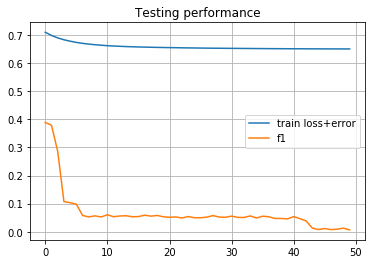

In [0]:
loss, acc, f1 = abModel.evaluate(test_Ab_pred, testAb_labels)
p3 = abModel.predict(test_Ab_pred)
print("Loss: ", loss)
print('Accuracy: ', acc)
# Show loss curves                                          
plt.figure()
plt.grid()                                              
                                                            
plt.title('Testing performance')                          
plt.plot(h.epoch, h.history['loss'], label='train loss+error')  
plt.plot(h.epoch, h.history['f1'], label='f1')
plt.legend()

In [0]:
del train_Ab_pred
del abModel

###Overall Accuracy

In [0]:
from sklearn.metrics import accuracy_score

r = np.column_stack((testAb_labels, testACL_labels))
r = np.column_stack((r, testMen_labels))

p3 = np.array(p3)

[[0.3614338  0.2511899  0.36215752 ... 0.36215752 0.2511899  0.36215752]
 [0.3614338  0.2722913  0.36215752 ... 0.36215752 0.2722913  0.36215752]
 [0.3614338  0.15132624 0.36215752 ... 0.36215752 0.15132624 0.36215752]
 ...
 [0.2155416  0.2722913  0.36215752 ... 0.36215752 0.2722913  0.36215752]
 [0.3614338  0.2722913  0.36215752 ... 0.36215752 0.2722913  0.36215752]
 [0.3614338  0.2722913  0.36215752 ... 0.36215752 0.2722913  0.36215752]]


ValueError: ignored

In [0]:
s = p3[:,0]
s = np.column_stack((s, np.array(p2)))
s = np.column_stack((s, np.array(p1)))

ValueError: ignored

In [0]:
tolerance = 1e-10
accuracy = (np.abs(s - r) < tolerance).all(axis=(0,1)).mean()
print(accuracy)

[[False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False False]
 [False False

#Plotting loss of both training and validation sets per epoch.

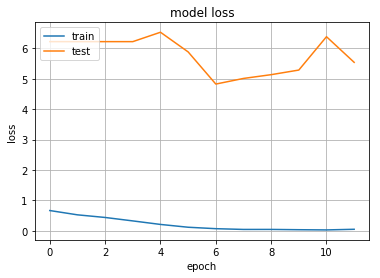

In [0]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

#Plotting Fscore of both training and validation sets per epoch.
lesa msh 3arfa a3melha

In [0]:

y_pred = model.predict(train_axial ,trainMen_labels,verbose=1)   
f_score=f1_score(trainMen_labels, y_pred, average='binary')
plt.plot(history.history['val_loss'])